# Simulation eines Matched-Filter Empfängers

Systemmodell: BPSK Quelle -> RRC Pulsformung -> AWGN Kanal -> Matched Filter -> Abtastung


## Generierung der BPSK Symbole und Upsampling

[]

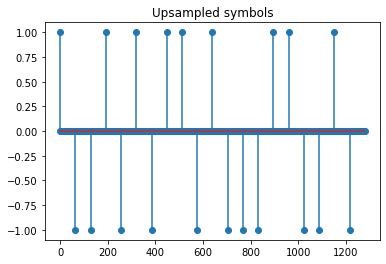

In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt

import rrc

N = 1024*16  # number of symbols
M = 64       # samples per symbol (oversampling factor)
K = 32       # length of impulse response in symbols

rolloff = 1 # RRC Rolloff factor

SNR = 15   # SNR in dB

sym = [random.choice([-1, 1]) for i in range(N)]
sym_up = np.zeros((M*N))
sym_up[::M] = sym  # upsampled symbols

plt.stem(sym_up[:20*M]); 
plt.title("Upsampled symbols"); plt.plot()

## Generierung des RRC Pulses

[]

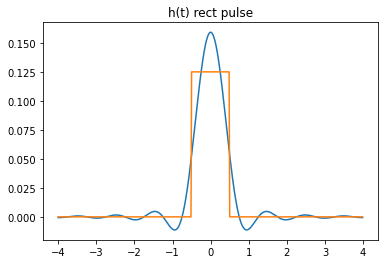

In [2]:
N_rrc = M*K+1
group_delay = int((N_rrc-1)/2)
g = rrc.get_rrc_ir(N_rrc, M, 1, rolloff)
g /= np.sqrt(np.sum(g**2))

Kplot = min(K//2, 4)
plt.plot(np.arange(-Kplot, Kplot, 1/M), g[len(g)//2-Kplot*M: len(g)//2+Kplot*M]); 
plt.title("h(t) RRC pulse"); plt.grid(); plt.plot()


g_rect = np.zeros(N_rrc)
g_rect[group_delay - int(M/2): group_delay + int(M/2)] = 1/np.sqrt(M)

plt.plot(np.arange(-Kplot, Kplot, 1/M), g_rect[len(g_rect)//2-Kplot*M: len(g_rect)//2+Kplot*M]); 
plt.title("h(t) rect pulse"); plt.grid(); plt.plot()

#g = g_rect

## Generierung des RC Pulses durch Faltung

[]

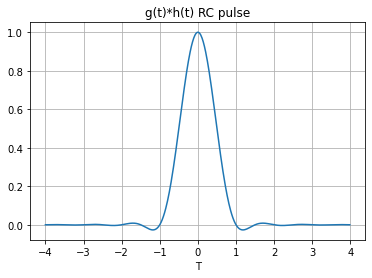

In [3]:
gh = np.convolve(g, g, mode='full')

plt.plot(np.arange(-Kplot, Kplot, 1/M), gh[len(gh)//2-Kplot*M: len(gh)//2+Kplot*M]); 
plt.title("g(t)*h(t) RC pulse"); plt.xlabel('T'); plt.grid(); plt.plot()

## Faltung der Sendesymbole mit dem Pulsformungsfilter

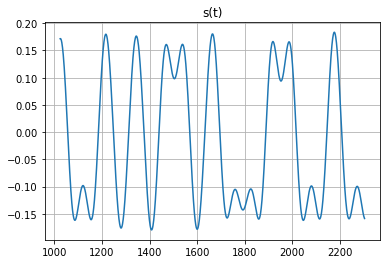

In [4]:
st = np.convolve(sym_up, g, mode='full')

plt.plot(np.arange(group_delay, 20*M+group_delay), st[group_delay:20*M+group_delay]); 
plt.title("s(t)"); plt.grid(); plt.show()

## AWGN-Kanal

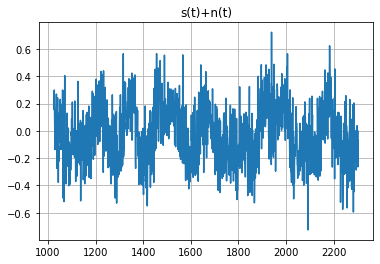

In [5]:
sigma2 = 10**(SNR/10)
nt = 1/(np.sqrt(sigma2))*np.random.randn(len(st))
snt = st + nt

plt.plot(np.arange(group_delay, 20*M+group_delay), snt[group_delay:20*M+group_delay]); 
plt.title("s(t)+n(t)"); plt.grid(); plt.show()

## Faltung mit Matched Filter am Empfänger

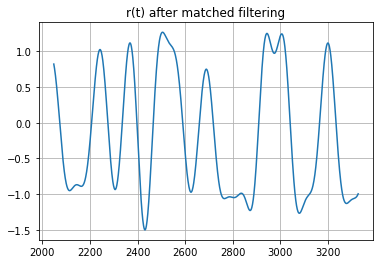

In [6]:
rt = np.convolve(snt, g, mode='full')

plt.plot(np.arange(2*group_delay, 20*M+2*group_delay), rt[2*group_delay:20*M+2*group_delay]); 
plt.title("r(t) after matched filtering"); plt.grid(); plt.show()

## Abtastung, Rekonstruktion der gesendeten Symbole

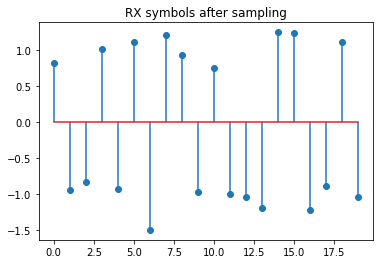

In [7]:
r = rt[2*group_delay:-2*group_delay:M]

plt.stem(r[:20]); 
plt.title("RX symbols after sampling"); plt.show()

# Symbolfehlerrate

In [8]:
sym_est = [1 if i > 0 else -1 for i in r[:N]]
SER = np.mean([tx!=rx for tx, rx in zip(sym, sym_est)])
print("Symbol error rate: "+str(SER))

Symbol error rate: 0.0
